In [ ]:
# Completely remove everything Python installed in site-packages
!rm -rf /usr/local/lib/python3.11/dist-packages/*
!pip uninstall -y numpy tensorflow pandas

# Reinstall the correct versions
!pip install numpy==1.23.5 pandas==1.5.3 tensorflow==2.13.0 --no-cache-dir firebase-admin --force-reinstall


Traceback (most recent call last):
  File "/usr/local/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'
Traceback (most recent call last):
  File "/usr/local/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'


In [ ]:
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import numpy as np

# Authenticate Firebase
cred = credentials.Certificate("/content/smart-agriculture-system-fd6a6-firebase-adminsdk-fbsvc-7ed7e93128.json")
firebase_admin.initialize_app(cred, {
    "databaseURL": "https://smart-agriculture-system-fd6a6-default-rtdb.asia-southeast1.firebasedatabase.app"
})

# Fetch data from Firebase
ref = db.reference("/hydroponic")
data = ref.get()

# Convert data to Pandas DataFrame
df = pd.DataFrame([data])
df.to_csv("sensor_data.csv", index=False)  # Save for backup

In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data for 1000 timestamps
data_size = 1000
temperature = np.random.uniform(20, 35, data_size)  # Celsius
humidity = np.random.uniform(40, 80, data_size)  # Percentage
soil_moisture = np.random.uniform(200, 800, data_size)  # Arbitrary units
light_intensity = np.random.uniform(100, 1000, data_size)  # Lux
ph_level = np.random.uniform(5.5, 7.5, data_size)  # pH scale

# Simulated plant growth condition (1=Healthy, 0=Unhealthy)
growth_condition = np.random.choice([0, 1], size=data_size, p=[0.3, 0.7])

# Create DataFrame
df = pd.DataFrame({
    'temperature': temperature,
    'humidity': humidity,
    'soil_moisture': soil_moisture,
    'light_intensity': light_intensity,
    'ph_level': ph_level,
    'growth_condition': growth_condition,
})

# Save as CSV
df.to_csv("sensor_data.csv", index=False)
print("Synthetic dataset created successfully!")

Synthetic dataset created successfully!


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load data
df = pd.read_csv("sensor_data.csv")

# Define features (X) and target (y)
X = df.drop(columns=['Pump_Status'])
y = df['Pump_Status']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")


Decision Tree Accuracy: 1.00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['Pump_Status']))
X_lstm = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))
y_lstm = df['Pump_Status'].values

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import numpy as np

# Optional: Ensure data is float32 for TensorFlow compatibility
X_train_lstm = np.array(X_train_lstm, dtype=np.float32)
X_test_lstm = np.array(X_test_lstm, dtype=np.float32)
y_train_lstm = np.array(y_train_lstm, dtype=np.float32)
y_test_lstm = np.array(y_test_lstm, dtype=np.float32)

# Define callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)
checkpoint = callbacks.ModelCheckpoint(
    'best_lstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1
)

# Build the LSTM model (compatible with TFLite)
model = keras.Sequential([
    layers.Input(shape=(1, X_train_lstm.shape[2])),
    layers.LSTM(64, return_sequences=True, unroll=True, implementation=2),
    layers.Dropout(0.3),
    layers.LSTM(32, unroll=True, implementation=2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"\n✅ Final LSTM Model Accuracy: {test_acc:.4f}")


Epoch 1/50
43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8861 - loss: 0.6535
Epoch 1: val_loss improved from inf to 0.35756, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8973 - loss: 0.6416 - val_accuracy: 0.9500 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 2/50
35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9651 - loss: 0.2457
Epoch 2: val_loss improved from 0.35756 to 0.22493, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9676 - loss: 0.2190 - val_accuracy: 0.9500 - val_loss: 0.2249 - learning_rate: 0.0010
Epoch 3/50
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9688 - loss: 0.1358
Epoch 3: val_loss improved from 0.22493 to 0.20855, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9694 - loss: 0.1332 - val_accuracy: 0.9500 - val_loss: 0.2085 - learning_rate: 0.0010
Epoch 4/50
34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9726 - loss: 0.1056
Epoch 4: val_loss improved from 0.20855 to 0.18927, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9726 - loss: 0.1078 - val_accuracy: 0.9500 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 5/50
35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9716 - loss: 0.1151
Epoch 5: val_loss did not improve from 0.18927
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9730 - loss: 0.1101 - val_accuracy: 0.9500 - val_loss: 0.1896 - learning_rate: 0.0010
Epoch 6/50
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9771 - loss: 0.0926
Epoch 6: val_loss improved from 0.18927 to 0.16490, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9769 - loss: 0.0933 - val_accuracy: 0.9500 - val_loss: 0.1649 - learning_rate: 0.0010
Epoch 7/50
34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9737 - loss: 0.0954
Epoch 7: val_loss improved from 0.16490 to 0.15717, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9741 - loss: 0.0937 - val_accuracy: 0.9500 - val_loss: 0.1572 - learning_rate: 0.0010
Epoch 8/50
44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9661 - loss: 0.0953
Epoch 8: val_loss improved from 0.15717 to 0.14551, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9672 - loss: 0.0929 - val_accuracy: 0.9500 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 9/50
33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.0636
Epoch 9: val_loss improved from 0.14551 to 0.12405, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9790 - loss: 0.0662 - val_accuracy: 0.9500 - val_loss: 0.1241 - learning_rate: 0.0010
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9801 - loss: 0.0564
Epoch 10: val_loss improved from 0.12405 to 0.11428, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9800 - loss: 0.0565 - val_accuracy: 0.9500 - val_loss: 0.1143 - learning_rate: 0.0010
Epoch 11/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9661 - loss: 0.0794
Epoch 11: val_loss improved from 0.11428 to 0.10805, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9666 - loss: 0.0785 - val_accuracy: 0.9500 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 12/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9740 - loss: 0.0540
Epoch 12: val_loss improved from 0.10805 to 0.08599, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9741 - loss: 0.0541 - val_accuracy: 0.9500 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 13/50
39/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9743 - loss: 0.0583
Epoch 13: val_loss did not improve from 0.08599
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.0567 - val_accuracy: 0.9500 - val_loss: 0.0896 - learning_rate: 0.0010
Epoch 14/50
35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9705 - loss: 0.0582
Epoch 14: val_loss did not improve from 0.08599
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9733 - loss: 0.0554 - val_accuracy: 0.9500 - val_loss: 0.0879 - learning_rate: 0.0010
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9786 - loss: 0.0543
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: val_loss did not improve from 0.08599
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9787 - loss: 0.0541 - val_accuracy: 0.9500 - val_los

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9783 - loss: 0.0405 - val_accuracy: 0.9550 - val_loss: 0.0827 - learning_rate: 5.0000e-04
Epoch 17/50
33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.0331
Epoch 17: val_loss improved from 0.08274 to 0.07081, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9829 - loss: 0.0358 - val_accuracy: 0.9650 - val_loss: 0.0708 - learning_rate: 5.0000e-04
Epoch 18/50
43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9880 - loss: 0.0286
Epoch 18: val_loss improved from 0.07081 to 0.06889, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9874 - loss: 0.0306 - val_accuracy: 0.9650 - val_loss: 0.0689 - learning_rate: 5.0000e-04
Epoch 19/50
44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9801 - loss: 0.0447
Epoch 19: val_loss improved from 0.06889 to 0.06851, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9805 - loss: 0.0442 - val_accuracy: 0.9650 - val_loss: 0.0685 - learning_rate: 5.0000e-04
Epoch 20/50
43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.0339
Epoch 20: val_loss did not improve from 0.06851
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9855 - loss: 0.0346 - val_accuracy: 0.9650 - val_loss: 0.0687 - learning_rate: 5.0000e-04
Epoch 21/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9888 - loss: 0.0374
Epoch 21: val_loss improved from 0.06851 to 0.06648, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9883 - loss: 0.0375 - val_accuracy: 0.9700 - val_loss: 0.0665 - learning_rate: 5.0000e-04
Epoch 22/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9836 - loss: 0.0423
Epoch 22: val_loss did not improve from 0.06648
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9837 - loss: 0.0420 - val_accuracy: 0.9700 - val_loss: 0.0666 - learning_rate: 5.0000e-04
Epoch 23/50
45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9871 - loss: 0.0422
Epoch 23: val_loss improved from 0.06648 to 0.06456, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9870 - loss: 0.0419 - val_accuracy: 0.9700 - val_loss: 0.0646 - learning_rate: 5.0000e-04
Epoch 24/50
43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9725 - loss: 0.0520
Epoch 24: val_loss improved from 0.06456 to 0.05862, saving model to best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9739 - loss: 0.0502 - val_accuracy: 0.9700 - val_loss: 0.0586 - learning_rate: 5.0000e-04
Epoch 25/50
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9914 - loss: 0.0277
Epoch 25: val_loss did not improve from 0.05862
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9910 - loss: 0.0281 - val_accuracy: 0.9750 - val_loss: 0.0615 - learning_rate: 5.0000e-04
Epoch 26/50
41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9948 - loss: 0.0237
Epoch 26: val_loss did not improve from 0.05862
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9936 - loss: 0.0255 - val_accuracy: 0.9700 - val_loss: 0.0759 - learning_rate: 5.0000e-04
Epoch 27/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9858 - loss: 0.0367
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 27: val_loss did not improve from 0.05862
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9858 - loss: 0.0365 - val_accuracy: 0.97

In [ ]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model("/content/best_lstm_model.h5")

# Get the input shape of the model
input_shape = model.input_shape  # (None, 1, num_features)
print(f"Model Input Shape: {input_shape}")

# Define a concrete function from the model
@tf.function(input_signature=[tf.TensorSpec(shape=input_shape, dtype=tf.float32)])
def model_func(x):
    return model(x)

# Convert using the concrete function
concrete_func = model_func.get_concrete_function()
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

# Required for LSTM
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Optional: Enable optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert and save
try:
    tflite_model = converter.convert()
    with open("lstm_hydroponic.tflite", "wb") as f:
        f.write(tflite_model)
    print("✅ TFLite Model Created Successfully!")
except Exception as e:
    print("❌ Conversion failed:", e)


Model Input Shape: (None, 1, 5)
✅ TFLite Model Created Successfully!


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       190
           1       1.00      1.00      1.00        10

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



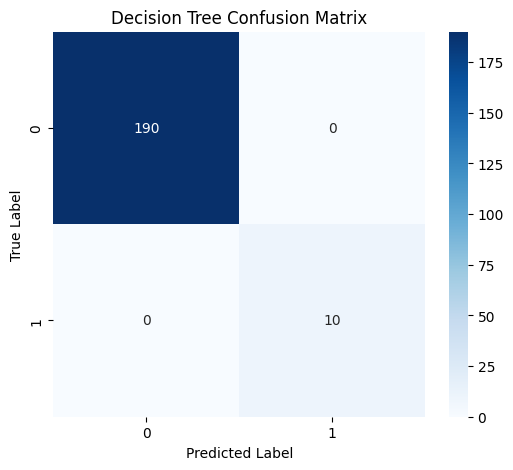

In [ ]:
# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree Confusion Matrix")
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


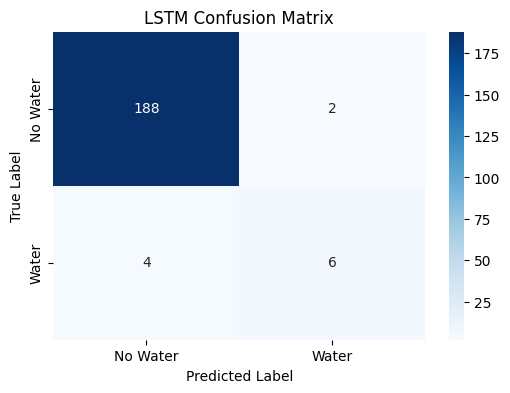

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9792    0.9895    0.9843       190
         1.0     0.7500    0.6000    0.6667        10

    accuracy                         0.9700       200
   macro avg     0.8646    0.7947    0.8255       200
weighted avg     0.9677    0.9700    0.9684       200



In [ ]:
# Step 1: Predict probabilities
y_pred_probs = model.predict(X_test_lstm)

# Step 2: Convert probabilities to binary labels
y_pred_lstm = (y_pred_probs > 0.5).astype(int)

# Step 3: Create confusion matrix
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)

# Step 4: Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Water", "Water"], yticklabels=["No Water", "Water"])
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 5: Print classification report
print("Classification Report:\n", classification_report(y_test_lstm, y_pred_lstm, digits=4))

In [ ]:
!pip install flask-ngrok

In [ ]:
!pip install flask flask-cors pyngrok

In [ ]:
!ngrok config add-authtoken 2vIw1qio1LZiqY9tMoMSlgL32yb_23Ue3rsTDCnb39Fdz4McJ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok
import tensorflow as tf
import numpy as np

# Load your model
model = tf.keras.models.load_model("/content/best_lstm_model.h5")

# Initialize Flask
app = Flask(__name__)
CORS(app)

@app.route("/")
def home():
    return "🔥 ML Model is running!"

@app.route("/predict", methods=["POST"])
def predict():
    try:
        data = request.get_json()
        temp = float(data['temperature'])
        humidity = float(data['humidity'])
        moisture = float(data['soil_moisture'])
        ph = float(data['ph'])
        ldr = float(data['light'])

        input_data = np.array([[temp, humidity, soil_moisture, ph, light]])
        prediction = model.predict(input_data)[0][0]

        return jsonify({"prediction": float(prediction)})
    except Exception as e:
        return jsonify({"error": str(e)})

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print(f"🌐 Public URL: {public_url}")

# Start Flask app
app.run(port=5000)

🌐 Public URL: NgrokTunnel: "https://8c89-34-73-150-177.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:03:40] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:03:41] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:18:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:29:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:30:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:30:35] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:30:59] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:31:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:31:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2025 07:32:13] "POST /predi